# Bayesian Optimization in JT VAE for Molecule Generation

### 1) Sparse Gaussian Process Regression

First generate latent representations using `gen_latent.py` <br>
Use `generate_train_data()` to generate training and testing data <br>
Create a `Sparse_GP` instance and call `train()` to perform a SGP regressian on the training data

In [1]:
from util import *
import numpy as np

In [2]:
# Define your own training data or
# We load the data (y is minued!)

training_num = 100000
feature_dir = './bo/latent_features2.txt'
target_dir = './bo/targets2.txt'

X = np.loadtxt(feature_dir)[:training_num]
y = -np.loadtxt(target_dir)[:training_num]
y = y.reshape((-1, 1))
device = "cuda"

X_train, y_train, X_test, y_test = generate_train_data(X, y, device)

Training data shape X:torch.Size([90000, 56]), y:torch.Size([90000])
Testing data shape X:torch.Size([10000, 56]), y:torch.Size([10000])


In [3]:
#Load sparse Gaussian process regression model and fit the training data

from SGPmodel import *
SGP = Sparse_GP(X_train, y_train, device, 1000)
with gpytorch.settings.use_toeplitz(True):
    SGP.train(200)

Iter 20/200 - Loss: 2.236
Iter 40/200 - Loss: 2.158
Iter 60/200 - Loss: 1.952
Iter 80/200 - Loss: 1.767
Iter 100/200 - Loss: 1.644
Iter 120/200 - Loss: 1.558
Iter 140/200 - Loss: 1.477
Iter 160/200 - Loss: 1.479
Iter 180/200 - Loss: 1.522
Iter 200/200 - Loss: 1.511


In [4]:
# Test MLL and RMSE on test data

SGP.model.eval()
SGP.likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
        preds = SGP.model(X_test)
MLL = -SGP.mll(preds, y_test)
RMSE = np.sqrt(np.mean((preds.mean.cpu().numpy() - y_test.cpu().numpy())**2))
print("Test MLL:", MLL.item())
print("Test RMSE: ", RMSE)

Test MLL: 1.6187447309494019
Test RMSE:  1.2427152


### 2) Bayesian Optimization

Specify your `vocab_path` and `model_path` <br>
Use `make_vae_model()` to load junction tree VAE model and use `BayesianOpt()` to perform BO

In [5]:
# Load VAE model
vocab_path = "/home/ubuntu/ASAIL/jtnn_bo/jtnn/vocab.txt"
model_path = "model.iter-0-3000"
JT_model = make_vae_model(vocab_path, model_path, device="cuda")

In [9]:
# Start Bayesian optimization for 10 iterations
SGP.model.set_train_data(X_train, y_train, strict = False)
with gpytorch.settings.cg_tolerance(10), gpytorch.settings.max_cg_iterations(1500):
    valid_s, mol_score = BayesianOpt(JT_model, SGP.model, SGP.likelihood, max_iteration=10)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 11.288341522216797 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


new x score: 2.8544740444049603
train with X.shape - torch.Size([90001, 56]), y.shape - torch.Size([90001])
Iter 10/50 - Loss: 0.879  noise: 0.002
Iter 20/50 - Loss: 0.850  noise: 0.002
Iter 30/50 - Loss: 0.851  noise: 0.002
Iter 40/50 - Loss: 0.838  noise: 0.002
Iter 50/50 - Loss: 0.830  noise: 0.002
1  new molecules are found. Iteration- 0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 15.046937942504883 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: -13.294374480589708
train with X.shape - torch.Size([90002, 56]), y.shape - torch.Size([90002])
Iter 10/50 - Loss: 0.827  noise: 0.002
Iter 20/50 - Loss: 0.822  noise: 0.001
Iter 30/50 - Loss: 0.813  noise: 0.001
Iter 40/50 - Loss: 0.803  noise: 0.001
Iter 50/50 - Loss: 0.796  noise: 0.001
1  new molecules are found. Iteration- 1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 5746.97119140625 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 1.4963669441699667
train with X.shape - torch.Size([90003, 56]), y.shape - torch.Size([90003])
Iter 10/50 - Loss: 0.796  noise: 0.001
Iter 20/50 - Loss: 0.789  noise: 0.001
Iter 30/50 - Loss: 0.783  noise: 0.001
Iter 40/50 - Loss: 0.778  noise: 0.001
Iter 50/50 - Loss: 0.770  noise: 0.001
1  new molecules are found. Iteration- 2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 28.97286605834961 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 2.4535960020142955
train with X.shape - torch.Size([90004, 56]), y.shape - torch.Size([90004])
Iter 10/50 - Loss: 0.763  noise: 0.001
Iter 20/50 - Loss: 0.765  noise: 0.001
Iter 30/50 - Loss: 0.746  noise: 0.001
Iter 40/50 - Loss: 0.744  noise: 0.001
Iter 50/50 - Loss: 0.738  noise: 0.000
1  new molecules are found. Iteration- 3


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 8426.6044921875 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 1.4963669441699667
train with X.shape - torch.Size([90005, 56]), y.shape - torch.Size([90005])
Iter 10/50 - Loss: 0.743  noise: 0.000
Iter 20/50 - Loss: 0.729  noise: 0.000
Iter 30/50 - Loss: 0.724  noise: 0.000
Iter 40/50 - Loss: 0.718  noise: 0.000
Iter 50/50 - Loss: 0.714  noise: 0.000
1  new molecules are found. Iteration- 4


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 5172.4541015625 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 1.4963669441699667
train with X.shape - torch.Size([90006, 56]), y.shape - torch.Size([90006])
Iter 10/50 - Loss: 0.684  noise: 0.000
Iter 20/50 - Loss: 0.698  noise: 0.000
Iter 30/50 - Loss: 0.690  noise: 0.000
Iter 40/50 - Loss: 0.685  noise: 0.000
Iter 50/50 - Loss: 0.677  noise: 0.000
1  new molecules are found. Iteration- 5


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 8596.189453125 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 1.4963669441699667
train with X.shape - torch.Size([90007, 56]), y.shape - torch.Size([90007])
Iter 10/50 - Loss: 0.678  noise: 0.000
Iter 20/50 - Loss: 0.671  noise: 0.000
Iter 30/50 - Loss: 0.666  noise: 0.000
Iter 40/50 - Loss: 0.655  noise: 0.000
Iter 50/50 - Loss: 0.651  noise: 0.000
1  new molecules are found. Iteration- 6


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 3634.63037109375 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 9.134875447794862
train with X.shape - torch.Size([90008, 56]), y.shape - torch.Size([90008])
Iter 10/50 - Loss: 0.650  noise: 0.000
Iter 20/50 - Loss: 0.647  noise: 0.000
Iter 30/50 - Loss: 0.643  noise: 0.000
Iter 40/50 - Loss: 0.630  noise: 0.000
Iter 50/50 - Loss: 0.628  noise: 0.000
1  new molecules are found. Iteration- 7


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 1061.4200439453125 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 3.182474894497798
train with X.shape - torch.Size([90009, 56]), y.shape - torch.Size([90009])
Iter 10/50 - Loss: 0.620  noise: 0.000
Iter 20/50 - Loss: 0.610  noise: 0.000
Iter 30/50 - Loss: 0.607  noise: 0.000
Iter 40/50 - Loss: 0.606  noise: 0.000
Iter 50/50 - Loss: 0.621  noise: 0.000
1  new molecules are found. Iteration- 8


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1500 iterations with average residual norm 13525.244140625 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


new x score: 1.4963669441699667
1  new molecules are found. Iteration- 9


### 3) Visualization

use `draw_mol()` to visualize molecule structures

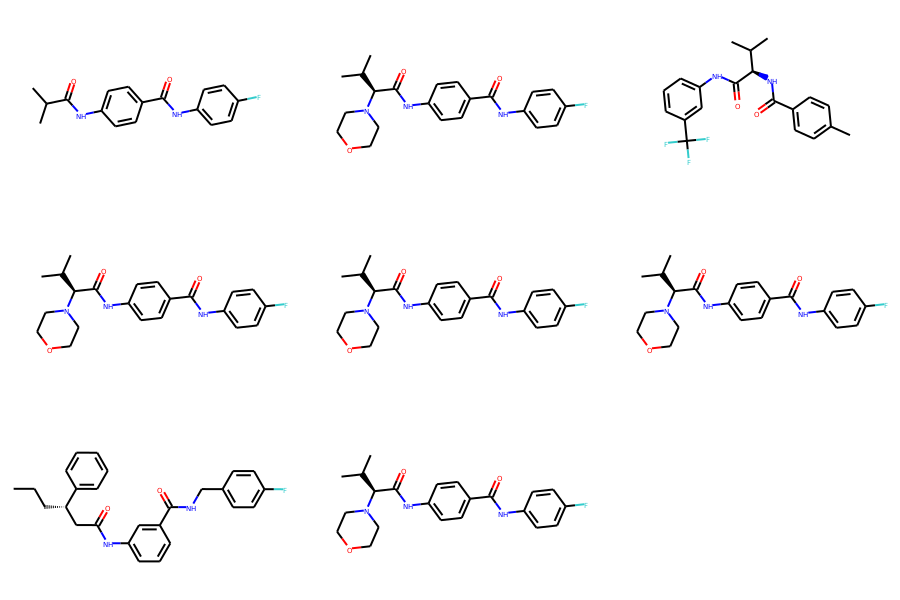

In [11]:
# filter unsatisfactoy molecules
good_s = []
for i, s in enumerate(valid_s):
    if "CCCCCCCCC" not in s and "C(C)(C)C(C)(C)C(C)(C)" not in s:
        good_s.append(s)
img = draw_mol(good_s)
img